# Train Keypoints Classifier, i.e. Pose Classifier

In this notebook we are going to train our own pose classifier in PyTorch based on the dataset we built from the python script and notebook `00` and `01` respectively.

**Before you go any further** make sure you have already created and saved your csv file in `./dataset-keypoints`.

Code adapted from this [repo](https://github.com/Alimustoofaa/YoloV8-Pose-Keypoint-Classification/tree/master).

First let's do some imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

##### Hyperparameters

Now let's define our hyperparameters:

In [30]:
device = 'mps' # change to 'cuda' or 'cpu' depending on your available device
num_epochs = 200
num_classes = 3
test_size = 0.3
batch_size = 128
learn_rate = 0.01
data_path = './dataset-keypoints/3-actions-keypoints.csv'

##### Read Dataset

Here, we are reading the first 5 rows of our dataset.

In [31]:
df = pd.read_csv(data_path)
df = df.drop('image_name', axis=1)
df.head()

,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0.630522,0.292420,0.000000,0.000000,0.628385,0.282521,0.000000,0.000000,0.614454,...,0.576317,0.501878,0.592858,0.621966,0.575138,0.639119,0.582006,0.745540,0.569192,0.774234
1,0,0.681688,0.297667,0.684867,0.284273,0.673643,0.285231,0.000000,0.000000,0.655792,...,0.635178,0.520172,0.666546,0.651259,0.633974,0.656017,0.693172,0.772091,0.653664,0.777751
2,0,0.681474,0.289756,0.684871,0.278767,0.675242,0.276887,0.000000,0.000000,0.656579,...,0.644236,0.521371,0.663531,0.656392,0.636266,0.655713,0.645444,0.772805,0.603741,0.770249
3,0,0.568884,0.300921,0.576102,0.283987,0.563148,0.286170,0.595002,0.275965,0.560309,...,0.572276,0.543972,0.626724,0.692307,0.576633,0.694976,0.628285,0.824073,0.589432,0.816892
4,0,0.534133,0.342536,0.535527,0.327394,0.531565,0.332998,0.552751,0.307001,0.000000,...,0.593053,0.529043,0.626281,0.667443,0.585561,0.654329,0.634993,0.798154,0.598752,0.777337


##### Count and plot our data per class

In the following two cells, we are counting and plotting the number of data per class.

In [32]:
df.label.value_counts()

label
0    1030
2    1013
1     784
Name: count, dtype: int64

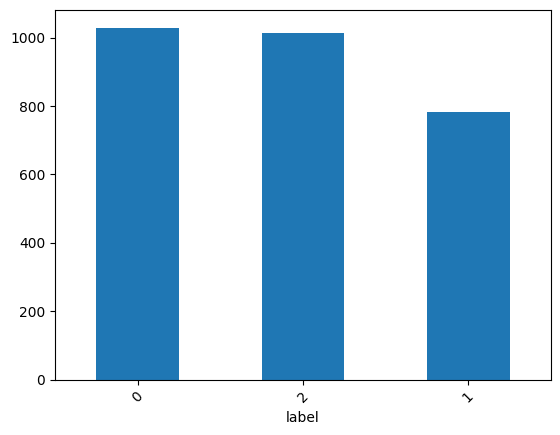

In [33]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

##### Define the 1st column as our labels `y` and the following 34 columns as our keypoints input dataset `X`

In [34]:
# Use the encoder label, to turn each label into an index number
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([0, 0, 0, ..., 2, 2, 2])

In [35]:
# Get keypoint dataset 
X = df.iloc[:, 1:] # start from 1: if you want all keypoints or 11: if you want to skip the keipoints of the face
X

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.630522,0.292420,0.000000,0.000000,0.628385,0.282521,0.000000,0.000000,0.614454,0.284529,...,0.576317,0.501878,0.592858,0.621966,0.575138,0.639119,0.582006,0.745540,0.569192,0.774234
1,0.681688,0.297667,0.684867,0.284273,0.673643,0.285231,0.000000,0.000000,0.655792,0.287324,...,0.635178,0.520172,0.666546,0.651259,0.633974,0.656017,0.693172,0.772091,0.653664,0.777751
2,0.681474,0.289756,0.684871,0.278767,0.675242,0.276887,0.000000,0.000000,0.656579,0.277180,...,0.644236,0.521371,0.663531,0.656392,0.636266,0.655713,0.645444,0.772805,0.603741,0.770249
3,0.568884,0.300921,0.576102,0.283987,0.563148,0.286170,0.595002,0.275965,0.560309,0.282752,...,0.572276,0.543972,0.626724,0.692307,0.576633,0.694976,0.628285,0.824073,0.589432,0.816892
4,0.534133,0.342536,0.535527,0.327394,0.531565,0.332998,0.552751,0.307001,0.000000,0.000000,...,0.593053,0.529043,0.626281,0.667443,0.585561,0.654329,0.634993,0.798154,0.598752,0.777337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,0.748850,0.282799,0.000000,0.000000,0.747167,0.273104,0.000000,0.000000,0.733290,0.272111,...,0.685256,0.490399,0.676404,0.607211,0.705255,0.630743,0.664867,0.729129,0.696614,0.773889
2823,0.449869,0.441833,0.451564,0.428795,0.000000,0.000000,0.466459,0.412090,0.000000,0.000000,...,0.585126,0.574670,0.488431,0.692309,0.549347,0.663077,0.506137,0.853177,0.576423,0.800012
2824,0.662125,0.237072,0.670356,0.226703,0.655743,0.225252,0.687270,0.231782,0.649893,0.229688,...,0.639248,0.502084,0.700923,0.655584,0.625162,0.644098,0.733703,0.796629,0.626807,0.778193
2825,0.804203,0.428461,0.000000,0.000000,0.801728,0.418048,0.000000,0.000000,0.786446,0.409770,...,0.702342,0.565212,0.720261,0.642994,0.763492,0.682178,0.683517,0.752115,0.720084,0.825958


##### Train Test Split

Perform a train-test split with test_size=0.3 (defined in our hyperparameters), and a random but deterministic split and a stratification.

Stratified sampling is a method of sampling that involves dividing a population into homogeneous subgroups known as strata, and then sampling from each stratum.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

Number of Training keypoints:  1978
Number of Testing keypoints:  849


In [37]:
# A glimpse into the test data in a table format
X_test

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
1603,0.601359,0.197260,0.606201,0.187243,0.594756,0.187338,0.610920,0.197533,0.582828,0.197983,...,0.574609,0.452237,0.605674,0.594220,0.583103,0.586866,0.618632,0.728880,0.595668,0.716876
1577,0.635560,0.197441,0.637090,0.187423,0.628568,0.187881,0.000000,0.000000,0.610194,0.198478,...,0.600604,0.453923,0.626814,0.585264,0.593422,0.586881,0.627323,0.712278,0.593305,0.713686
2687,0.545531,0.516536,0.547526,0.503098,0.000000,0.000000,0.565790,0.489382,0.000000,0.000000,...,0.651543,0.636040,0.619339,0.736063,0.578556,0.671400,0.659871,0.894934,0.617339,0.790411
936,0.594329,0.304433,0.598251,0.289928,0.586356,0.289034,0.000000,0.000000,0.566213,0.286518,...,0.552356,0.554071,0.592396,0.694962,0.545274,0.687476,0.586661,0.822641,0.535980,0.813661
2701,0.774109,0.401070,0.000000,0.000000,0.769581,0.389357,0.000000,0.000000,0.751015,0.383481,...,0.671556,0.564193,0.708756,0.632911,0.727585,0.684392,0.680926,0.743299,0.696976,0.828713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,0.630909,0.200620,0.632866,0.190625,0.624364,0.190391,0.000000,0.000000,0.607172,0.199057,...,0.597838,0.455177,0.624535,0.585859,0.591774,0.587530,0.627252,0.711672,0.592680,0.714055
1642,0.588353,0.202330,0.595453,0.192013,0.586345,0.191484,0.614842,0.201132,0.000000,0.000000,...,0.582285,0.455356,0.620948,0.590730,0.591188,0.588560,0.627288,0.713686,0.597751,0.716485
577,0.535640,0.299380,0.000000,0.000000,0.532454,0.282363,0.000000,0.000000,0.510100,0.276535,...,0.501858,0.538282,0.471864,0.677491,0.504913,0.692380,0.466194,0.823359,0.487701,0.851650
1758,0.656828,0.201498,0.000000,0.000000,0.653536,0.190658,0.000000,0.000000,0.638497,0.196222,...,0.627020,0.458261,0.618609,0.594513,0.613333,0.601707,0.623074,0.724196,0.616192,0.738559


##### MinMax scaling to scale each feature into a given range

For more information, look [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [38]:
# A glipse into the test data in the format of an array and after performing a minmax scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

array([[0.68696014, 0.31413503, 0.68879778, ..., 0.19623052, 0.57124727,
        0.13475377],
       [0.72602975, 0.31442204, 0.72389457, ..., 0.1455978 , 0.56609666,
        0.12499269],
       [0.62318524, 0.822578  , 0.62212818, ..., 0.70266782, 0.61848792,
        0.35978304],
       ...,
       [0.61188584, 0.47675985, 0.        , ..., 0.48437688, 0.33589162,
        0.54718549],
       [0.75032465, 0.32088364, 0.        , ..., 0.18194445, 0.6159865 ,
        0.20110648],
       [0.7258865 , 0.32590054, 0.72263634, ..., 0.14875667, 0.56125621,
        0.12602103]])

##### Data Loader

The data are currently numpy arrays and need to get transformed into torch tensors in order to get into the dataloaders.

In [39]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [40]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [41]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

##### Define our simple feed forward network

In [42]:
class NeuralNet(nn.Module):
    def __init__(self):
      super(NeuralNet, self).__init__()
      self.fc1 = nn.Linear(X_train.shape[1], 256)
      self.fc2 = nn.Linear(256, num_classes)     
  
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x


##### Setup core objects

Here we setup our core objects, the model, the loss function and the optimiser.

In [43]:
model = NeuralNet()
model.to(device)

# Cross entropy loss for training classification
criterion = nn.CrossEntropyLoss()

# Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

##### Training loop

Here is our training loop for our data.

In [44]:
train_losses = []
best_loss = 100000
for epoch in range(num_epochs):
    train_loss = 0.0
    
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Update model weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    # Normalise cumulative losses to dataset size
    train_loss = train_loss / len(train_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}')

Epoch 1, train loss: 0.964
Epoch 2, train loss: 0.720
Epoch 3, train loss: 0.627
Epoch 4, train loss: 0.602
Epoch 5, train loss: 0.590
Epoch 6, train loss: 0.593
Epoch 7, train loss: 0.584
Epoch 8, train loss: 0.580
Epoch 9, train loss: 0.574
Epoch 10, train loss: 0.571
Epoch 11, train loss: 0.570
Epoch 12, train loss: 0.569
Epoch 13, train loss: 0.572
Epoch 14, train loss: 0.568
Epoch 15, train loss: 0.565
Epoch 16, train loss: 0.565
Epoch 17, train loss: 0.563
Epoch 18, train loss: 0.564
Epoch 19, train loss: 0.568
Epoch 20, train loss: 0.567
Epoch 21, train loss: 0.574
Epoch 22, train loss: 0.572
Epoch 23, train loss: 0.566
Epoch 24, train loss: 0.571
Epoch 25, train loss: 0.567
Epoch 26, train loss: 0.567
Epoch 27, train loss: 0.562
Epoch 28, train loss: 0.568
Epoch 29, train loss: 0.563
Epoch 30, train loss: 0.560
Epoch 31, train loss: 0.561
Epoch 32, train loss: 0.560
Epoch 33, train loss: 0.564
Epoch 34, train loss: 0.558
Epoch 35, train loss: 0.559
Epoch 36, train loss: 0.561
E

##### Plot training loss

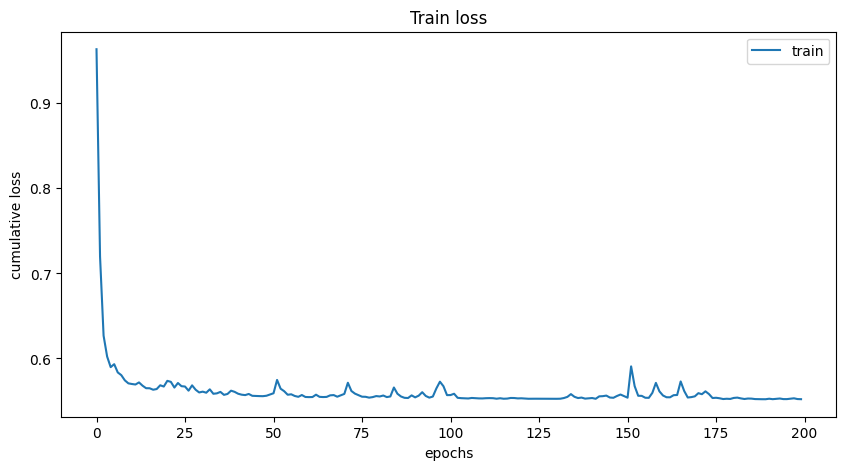

In [45]:
plt.figure(figsize=(10,5))
plt.title("Train loss")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

##### Test our model

Here we use the model to predict the label on unseen data, our test data.

The predictions are the predicted classes (in the encoded format 0-1-2) for each item in the test dataset.

In [46]:
# Prepare test features and labels
test_features = torch.from_numpy(X_test.astype(np.float32)).to(device)
test_labels = torch.from_numpy(y_test).to(device)

# Evaluate the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)

# Move predictions back to CPU if needed
predictions = predictions.cpu()

predictions

tensor([1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 0, 2, 2, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 0, 2, 0, 2, 1,
        2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2,
        0, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2,
        1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2,
        0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0,
        1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 2, 0, 1, 2,
        2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1,
        0, 2, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2,
        0, 2, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 1,
        2, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2,

##### Confusion Matrix

A confusion matrix is a really good way to visualise the number of true positives, false negatives, false positives, and true negatives.

The header row corresponds to the predicted labels while the first column corresponds to the ground truth.

In [47]:
# Move predictions and labels back to CPU
test_labels_cpu = test_labels.cpu()
predictions_cpu = predictions.cpu()

# Compute the confusion matrix
cm = confusion_matrix(test_labels_cpu.numpy(), predictions_cpu.numpy())

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(
    cm, 
    index = encoder.classes_,
    columns = encoder.classes_
)

df_cm

,0,1,2
0,309,0,0
1,0,236,0
2,3,0,301


##### Visualising the confusion matrix with a seaborn heatmap

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


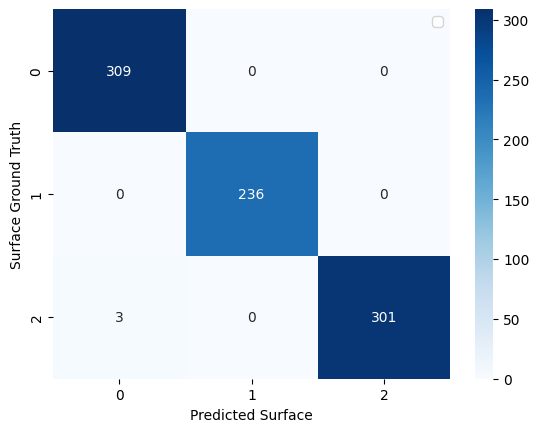

In [48]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()
    
show_confusion_matrix(df_cm)

##### Save model


In [49]:
PATH_SAVE = './classifier.pt'
torch.save(model.state_dict(), PATH_SAVE)